In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
from pathlib import Path
data_dir = Path("./../data")
df = pd.read_csv(data_dir.joinpath("./adult_train.csv"))
test = pd.read_csv(data_dir.joinpath("./adult_test.csv"))
test

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,gender,capital_gain,capital_loss,hours_per_week,native_country,income_bracket
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
32557,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
32558,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
32559,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K


In [3]:
num_cols = list(df.select_dtypes("number"))
target_col = ["income_bracket"]
total_cols = num_cols + target_col
data = df[total_cols]
y = data.pop(target_col[0])
X = data

In [4]:
testX = test[total_cols]
testY = testX.pop(target_col[0])

In [5]:
input_dim = X.shape[1]
feature_dim = 20

In [6]:
from ndf import FeedForward , NeuralDecisionForest ,Forest

feature_layer = FeedForward(
    input_dim=input_dim, output_dim=feature_dim, layers=[25, 25], activation="tanh", bn="batch_norm", last_logit=True
)
forest_param = dict(
    n_tree=5, tree_depth=3, n_in_feature=feature_dim, tree_feature_rate=0.5, n_class=2, jointly_training=True
)
forest = Forest(**forest_param)
nnForest = NeuralDecisionForest(feature_layer=feature_layer, forest=forest)

In [7]:
import torch
def prepare_optim(model, lr):
    params = [p for p in model.parameters() if p.requires_grad]
    return torch.optim.Adam(params, lr=lr, weight_decay=1e-5)

In [8]:
from sklearn.preprocessing import LabelEncoder
import numpy as np 

In [9]:
from torch.utils.data import DataLoader
from ndf import TabularNumDataset


dataset = TabularNumDataset(data.values , y.values)
testdataset = TabularNumDataset(testX.values , testY.values)
dataloader = DataLoader(dataset, batch_size=2, shuffle=True)

In [10]:
optim = prepare_optim(nnForest, 1e-5)
batch_x , batch_y = next(iter(dataloader))

In [11]:
output = nnForest((batch_x,))
output

tensor([[0.4862, 0.5138],
        [0.4846, 0.5154]], grad_fn=<DivBackward0>)

In [12]:
from ndf import ClassificationMetric

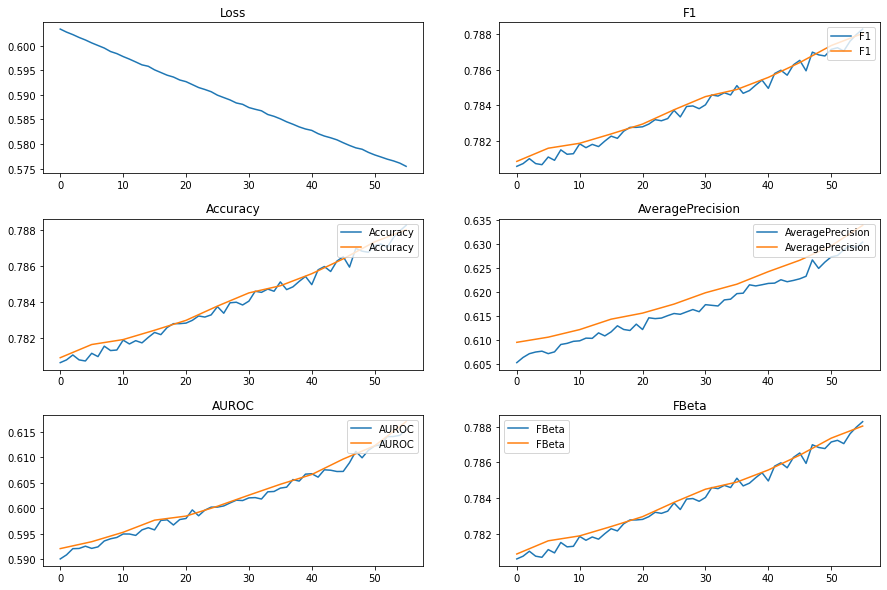

KeyboardInterrupt: 

In [22]:
import torchmetrics 
import matplotlib.pyplot as plt 
from IPython.display import clear_output
import torch.nn.functional as F
import matplotlib.pyplot as plt 
from pathlib import Path
def train(model, optim, dataset, testdataset,**kwargs):
    Loss_Collection = dict(train=[], test=[], loss=[])
    metric = torchmetrics.F1()
    train_metrics = ClassificationMetric(metric_kwargs=dict(num_classes=2))
    test_metrics = ClassificationMetric(metric_kwargs=dict(num_classes=2))
    save_dir = kwargs.get("save_dir", "./")
    BEST_LOSS = np.inf
    for epoch in range(0, kwargs.get("n_epoch", 100)):
        model.train()
        
        trainloader = DataLoader(dataset, batch_size=kwargs.get("batch_size", 32), shuffle=kwargs.get("shuffle", True))
        Loss = []
        metric.reset()
        train_metrics.reset()
        for batch_idx, (batch_x, batch_y) in enumerate(trainloader):
            output = model((batch_x,))
            optim.zero_grad()
            loss = F.nll_loss(torch.log(output), batch_y.squeeze().long())
            loss.backward()
            optim.step()
            Loss.append(loss.detach().numpy())
            metric(output, batch_y.squeeze().long())
            train_metrics.update(output, batch_y.squeeze().long())
        else:
            f1 = metric.compute()
            result = train_metrics.compute()
            train_metrics.log(result)
            Loss_Collection["loss"].append(np.mean(Loss))
            Loss_Collection["train"].append(f1 * 100)
            if BEST_LOSS > np.mean(Loss):
                BEST_LOSS = np.mean(Loss)
                model.save(save_dir.joinpath("./model.pt"))
                torch.save(optim.state_dict(), save_dir.joinpath("./optim.pt"))

        if epoch % kwargs.get("n_log", 5) == 0:
            clear_output(wait=True)
            evalloader = DataLoader(testdataset, batch_size=kwargs.get("batch_size", 32), shuffle=False)

            metric.reset()
            model.eval()
            test_metrics.reset()
            for batch_idx, (batch_x, batch_y) in enumerate(evalloader):
                output = model((batch_x,))
                metric(output, batch_y.squeeze().long())
                test_metrics.update(output, batch_y.squeeze().long())
            else:
                result = test_metrics.compute()
                test_metrics.log(result)
                f1 = metric.compute()
            Loss_Collection["test"].append(f1 * 100)
            total_length = 1+len(test_metrics.history)
            figsize=5
            nROWS = 3
            nCols = int(np.ceil(total_length / nROWS))
            fig, ax = plt.subplots(nROWS, nCols, figsize=(nROWS*figsize, nCols*figsize))
            plt.subplots_adjust(hspace=0.3)
            axes = ax.flatten()
            logs_iter = [i * kwargs.get("n_log", 5) for i in range(len(Loss_Collection["test"]))]
            axes[0].plot(Loss_Collection["loss"])
            for idx , key in enumerate(list(test_metrics.history.keys())) :
                figure_idx = idx+1
                te_metric_result = test_metrics.history[key]
                tr_metric_result = train_metrics.history[key]
                
                
                axes[figure_idx].plot(tr_metric_result, label=f"train : {key}")
                axes[figure_idx].plot(logs_iter, te_metric_result, label=f"test : {key}")                
                axes[figure_idx].set_title(key)
                axes[figure_idx].legend(loc="upper right")
            axes[0].set_title("Loss")
            axes[0].legend()
            
            if kwargs.get("save_fig",None) is not None :
                plt.savefig(save_dir.joinpath(kwargs.get("save_fig",None)))
                plt.close()
            else :
                plt.show()


save_dir = Path("./../model")
save_dir.mkdir(exist_ok=True)
#nnForest.load(save_dir.joinpath("./model.pt"))
#optim.load_state_dict(torch.load(save_dir.joinpath("./optim.pt")))
train(nnForest , optim , dataset,testdataset,batch_size=512,n_epoch=100000,save_dir=save_dir)
        
        